In [1]:
import fiftyone as fo
import fiftyone.zoo as foz

dataset = foz.load_zoo_dataset("quickstart")

Dataset already downloaded
Loading existing dataset 'quickstart'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


In [2]:
dataset

Name:        quickstart
Media type:  image
Num samples: 200
Persistent:  True
Tags:        ['not working', 'not working', 'not working', 'not working', 'not working', 'not working', 'not working', 'not working']
Sample fields:
    id:           fiftyone.core.fields.ObjectIdField
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    uniqueness:   fiftyone.core.fields.FloatField
    predictions:  fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)

In [3]:
results = dataset.evaluate_detections(
    "predictions",
    gt_field="ground_truth",
    eval_key="eval",
)

Evaluating detections...
 100% |█████████████████| 200/200 [8.8s elapsed, 0s remaining, 16.4 samples/s]      


Connected to FiftyOne on port 5151 at localhost.
If you are not connecting to a remote session, you may need to start a new session and specify a port



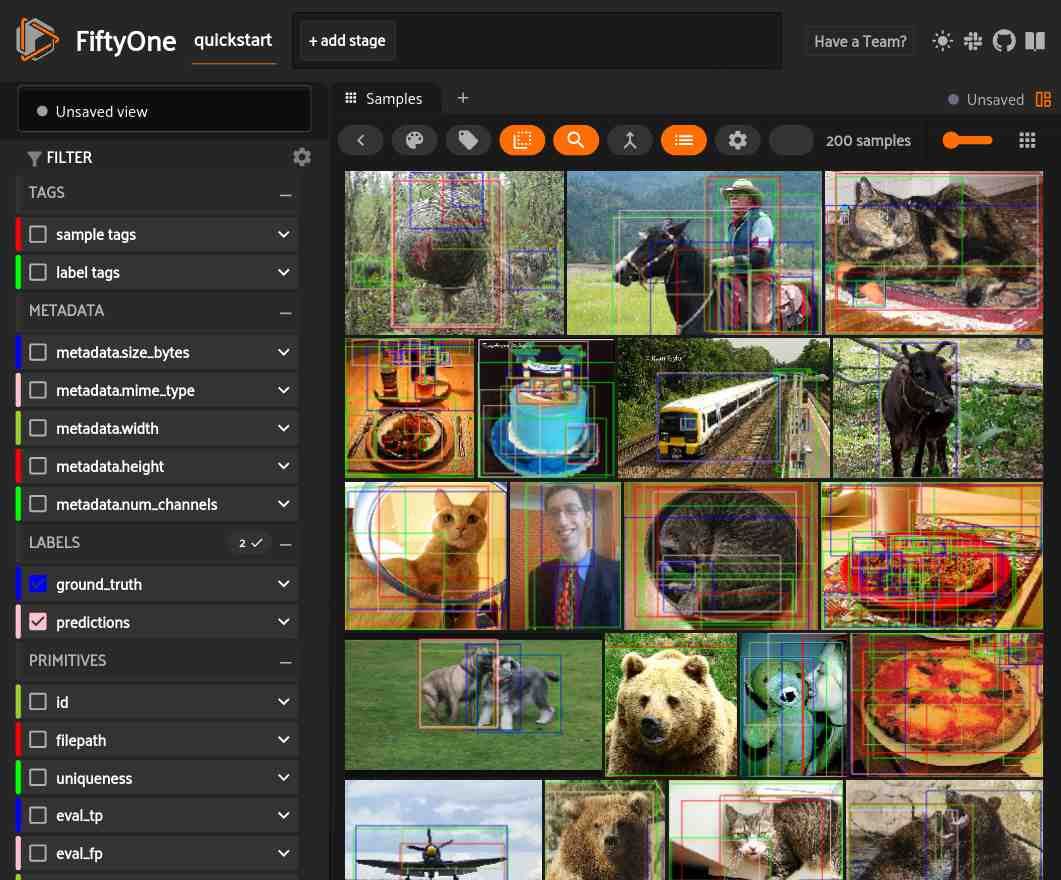

In [4]:
session = fo.launch_app(dataset)

In [5]:
import fiftyone.brain as fob

# Compute mistakenness of annotations in `ground_truth` field using
# predictions from `predictions` field as point of reference
fob.compute_mistakenness(dataset, "predictions", label_field="ground_truth")

Evaluating detections...
 100% |█████████████████| 200/200 [9.9s elapsed, 0s remaining, 15.3 samples/s]      
Computing mistakenness...
 100% |█████████████████| 200/200 [2.0s elapsed, 0s remaining, 87.4 samples/s]          
Mistakenness computation complete


In [6]:
from fiftyone import ViewField as F

# Sort by likelihood of mistake (most likely first)
mistake_view = dataset.sort_by("mistakenness", reverse=True)

# Print some information about the view
print(mistake_view)

Dataset:     quickstart
Media type:  image
Num samples: 200
Sample fields:
    id:                fiftyone.core.fields.ObjectIdField
    filepath:          fiftyone.core.fields.StringField
    tags:              fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:          fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    ground_truth:      fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    uniqueness:        fiftyone.core.fields.FloatField
    predictions:       fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    eval_tp:           fiftyone.core.fields.IntField
    eval_fp:           fiftyone.core.fields.IntField
    eval_fn:           fiftyone.core.fields.IntField
    mistakenness:      fiftyone.core.fields.FloatField
    possible_missing:  fiftyone.core.fields.IntField
    possible_spurious: fiftyone.core.fields.IntField
View stages:
    1. SortBy(field_or_expr='mist

In [ ]:
# Inspect some samples and detections
# This is the first detection of the first sample
print(mistake_view.first().ground_truth.detections[0])

In [ ]:
# Show the samples we processed in rank order by the mistakenness
session.view = mistake_view

In [ ]:
from fiftyone import ViewField as F

session.view = dataset.filter_labels("ground_truth", F("mistakenness") > 0.95)

In [ ]:
session.view = dataset.filter_labels("ground_truth", F("mistakenness_loc") > 0.85)

In [ ]:
session.view = dataset.match(F("possible_missing") > 0)